In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Any
import sys
import copy
import matplotlib.pyplot as plt

from src.dataclass import (
    Input, Lattice, Parameter, Train, Save,
    Processed_Input, Topology, Conjugate, Result
)
from src.manage_data import save_result, save_log, load_result

In [14]:
df = load_result()
df.columns.values

array(['key', 'state', 'size', 'dimension', 'ghost', 'initial', 'T', 'H',
       'Tc', 'Hc', 'Jm', 'Jv', 'mode', 'variable', 'multiply', 'base',
       'exponent', 'iteration', 'sweep', 'measurement', 'interval',
       'ensemble', 'max_workers', 'threshold', 'recent', 'environment',
       'save', 'order_parameter', 'susceptibility', 'binder_cumulant',
       'spin_glass_order', 'spin_glass_suscept', 'spin_glass_binder',
       'energy', 'specific_heat', 'irreducible_distance',
       'correlation_function', 'autocorrelation', 'time'], dtype=object)

In [15]:
df

,key,state,size,dimension,ghost,initial,T,H,Tc,Hc,...,binder_cumulant,spin_glass_order,spin_glass_suscept,spin_glass_binder,energy,specific_heat,irreducible_distance,correlation_function,autocorrelation,time
0,ae09fb,3,16,2,0,uniform,1.4984,0.0,1.5,0.0,...,0.095002,0.000334,1.203441e-04,-2.378041,-1.459474,0.791864,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9992643078786614, 0.44662481276708377, 0.27...","[1.0, 0.8208770751953125, 0.7628326416015625, ...",1165
1,521614,3,8,2,0,uniform,0.6808,0.0,1.5,0.0,...,0.666651,0.999054,1.559656e-05,0.666666,-1.998133,0.024721,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[0.0009462932325732254, 1.2604781431946321e-05...","[1.0, 0.99981689453125, 0.9996337890625, 0.999...",319
2,24638d,3,16,2,0,uniform,1.6024,0.0,1.5,0.0,...,0.060435,0.000167,2.542037e-05,-2.655543,-1.384818,0.731126,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.999693066502914, 0.4108166513773597, 0.2325...","[1.0, 0.798126220703125, 0.7322998046875, 0.68...",949
3,e489cf,3,16,2,0,uniform,1.3976,0.0,1.5,0.0,...,0.594588,0.419129,3.198651e-03,0.627877,-1.676912,1.704681,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.4894434666468055, 0.32790930834775733, 0.29...","[1.0, 0.953948974609375, 0.9306488037109375, 0...",1140
4,703974,3,8,2,0,uniform,1.5064,0.0,1.5,0.0,...,0.419703,0.001070,2.106895e-06,0.256517,-1.445323,2.590447,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[0.9978332176056028, 0.7205115926971075, 0.648...","[1.0, 0.92694091796875, 0.8963623046875, 0.871...",244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,e73155,3,8,2,0,uniform,1.4872,0.0,1.5,0.0,...,0.433522,0.001362,2.486381e-06,0.316702,-1.493971,2.453819,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[0.9967364638018807, 0.7437371008680884, 0.680...","[1.0, 0.93975830078125, 0.90643310546875, 0.88...",315
60,003092,3,16,2,0,uniform,2.3192,0.0,1.5,0.0,...,0.001019,0.000031,2.132688e-07,-2.492012,-0.535772,0.321690,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9999374148857214, 0.2678685531670908, 0.104...","[1.0, 0.719757080078125, 0.5335845947265625, 0...",1111
61,7410b4,3,16,2,0,uniform,1.4744,0.0,1.5,0.0,...,0.099816,0.000754,3.113449e-03,-2.102352,-1.482181,0.788845,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.998722279339745, 0.4530587889757669, 0.2795...","[1.0, 0.8214263916015625, 0.7667236328125, 0.7...",1174
62,c9deb8,3,8,2,0,uniform,1.5016,0.0,1.5,0.0,...,0.422390,0.001383,2.851141e-06,0.273709,-1.457727,2.560078,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[0.9977988747955351, 0.7266791842455405, 0.656...","[1.0, 0.93682861328125, 0.90423583984375, 0.87...",248


In [16]:
df.sort_values(by=['size', 'T'], ascending=[False, False])

,key,state,size,dimension,ghost,initial,T,H,Tc,Hc,...,binder_cumulant,spin_glass_order,spin_glass_suscept,spin_glass_binder,energy,specific_heat,irreducible_distance,correlation_function,autocorrelation,time
35,b200ab,3,16,2,0,uniform,2.3192,0.0,1.5,0.0,...,0.012582,0.000036,3.092035e-07,-2.746854,-0.974527,0.427768,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9999284586577915, 0.26635660033744557, 0.10...","[1.0, 0.6624908447265625, 0.523468017578125, 0...",972
60,003092,3,16,2,0,uniform,2.3192,0.0,1.5,0.0,...,0.001019,0.000031,2.132688e-07,-2.492012,-0.535772,0.321690,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9999374148857214, 0.2678685531670908, 0.104...","[1.0, 0.719757080078125, 0.5335845947265625, 0...",1111
33,5d5706,3,16,2,0,uniform,1.9096,0.0,1.5,0.0,...,0.005654,0.000034,2.967414e-07,-2.441313,-0.719518,0.635459,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9999327256716697, 0.35973128898748996, 0.18...","[1.0, 0.8320465087890625, 0.73065185546875, 0....",1132
63,bf3935,3,16,2,0,uniform,1.9096,0.0,1.5,0.0,...,0.024598,0.000055,1.072004e-06,-2.811139,-1.169852,0.583725,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9998886879511701, 0.33278344111607794, 0.15...","[1.0, 0.74072265625, 0.6405181884765625, 0.566...",960
18,adc3cc,3,16,2,0,uniform,1.7048,0.0,1.5,0.0,...,0.016358,0.000047,6.313934e-07,-1.903357,-0.890527,1.143562,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9999046015287831, 0.44520284516357833, 0.27...","[1.0, 0.8864288330078125, 0.833648681640625, 0...",1137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,b2c270,3,8,2,0,uniform,1.4488,0.0,1.5,0.0,...,0.459920,0.002786,4.183455e-06,0.366644,-1.581460,2.112230,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[0.9948101699264953, 0.7855531426178004, 0.737...","[1.0, 0.94049072265625, 0.91943359375, 0.89270...",272
12,98f973,3,8,2,0,uniform,1.3976,0.0,1.5,0.0,...,0.480172,0.008479,1.000910e-05,0.614263,-1.677147,1.639256,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[0.979560854052578, 0.818144283439209, 0.78540...","[1.0, 0.94708251953125, 0.9278564453125, 0.914...",238
6,cb21fe,3,8,2,0,uniform,1.2952,0.0,1.5,0.0,...,0.539458,0.153752,1.300036e-04,0.637301,-1.807386,0.969357,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[0.7629284746008305, 0.6666273570887322, 0.651...","[1.0, 0.968505859375, 0.9476318359375, 0.94470...",236
45,4512b5,3,8,2,0,uniform,1.0904,0.0,1.5,0.0,...,0.665807,0.964690,3.531746e-04,0.666658,-1.935879,0.379806,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]","[0.03530901461772373, 0.0032504005318969575, 0...","[1.0, 0.9857177734375, 0.9835205078125, 0.9802...",297


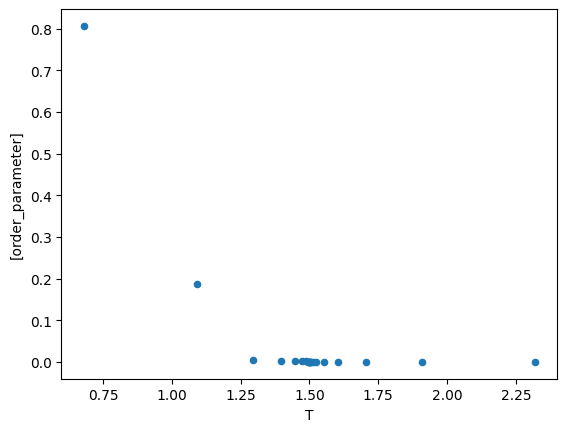

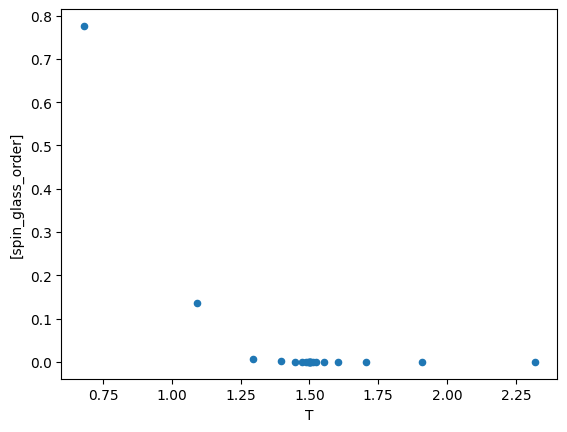

In [27]:
filter_ = (df['size'] == 16) & (df['Jv'] == 1.0)
df[filter_].plot(kind="scatter", x="T", y=["order_parameter"])
ax = plt.gca()
df[filter_].plot(kind="scatter", x="T", y=["spin_glass_order"])
plt.show()